# Project 5: Vehicle tracking and detection
**Aaron Smith**

## Overview
*Vehicle Detection Project*

*The goals / steps of this project are the following:*

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Writeup / README (Rubric Point)
This document serves as the writeup for this project.

In [454]:
import numpy as np
import cv2
import glob
from skimage.io import imread, imsave
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib
import cv2

from skimage.io import imread
from scipy.stats import describe
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from skimage.transform import pyramid_gaussian, pyramid_reduce
from sklearn.externals import joblib
import pickle
from scipy.ndimage.measurements import label

matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

## Vehicle classification
To give an idea of the concrete goal of this project, two images are shown below. One is a "vehicle" class image, the other a "non-vehicle."  My goal is to train a classifier which can identify vehicles successfully, and then apply that classification to frames of a video to draw bounding boxes around vehicles on the road.

### Vehicle image vs. non-vehicle image

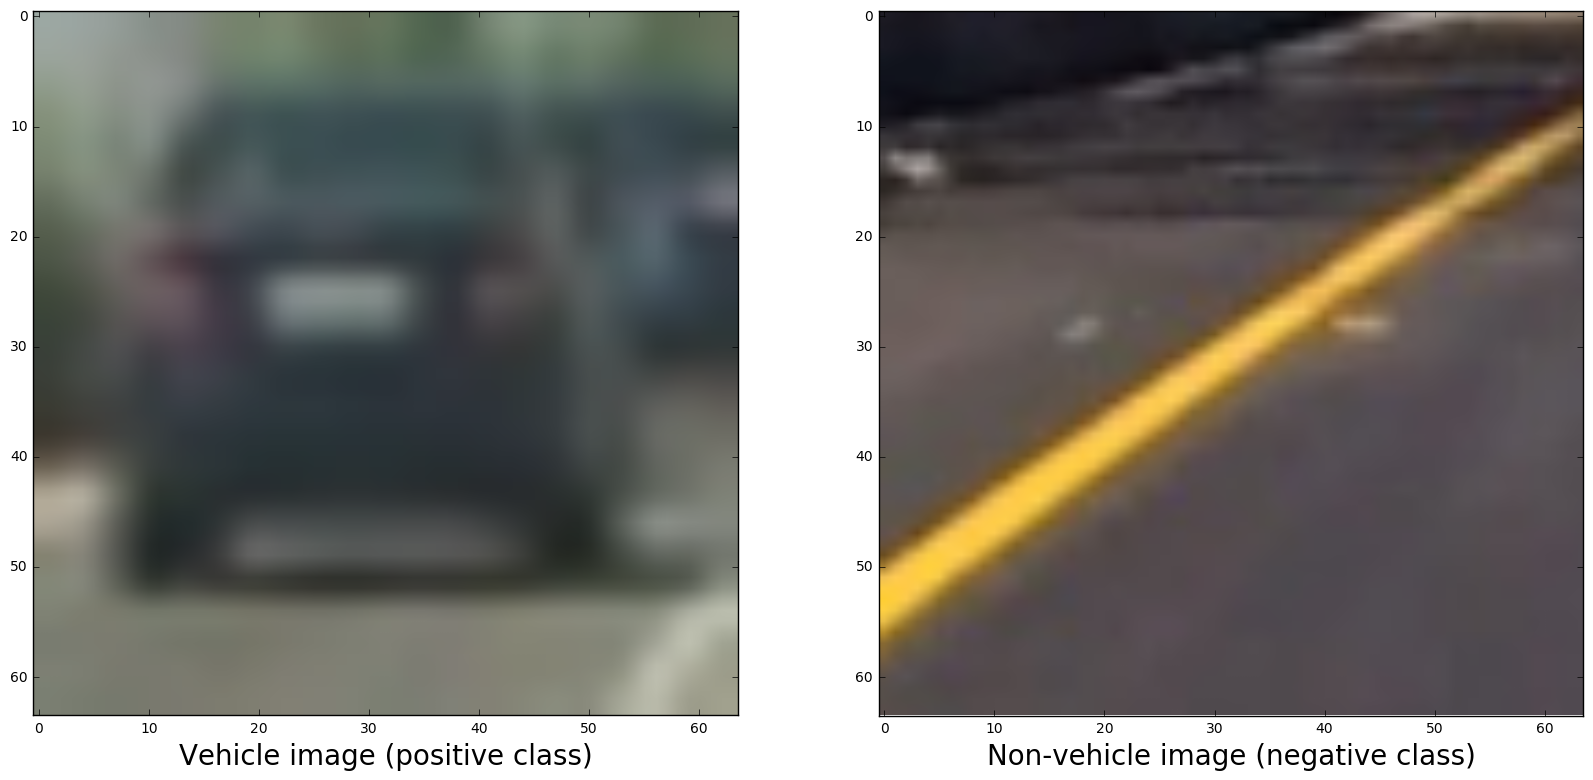

In [414]:
VEHICLE_IMAGE_LOCATION = "data/vehicles/*.png"
NON_VEHICLE_IMAGE_LOCATION = "data/non-vehicles/*.png"

vehicle_test_image = imread("data/vehicles/image0000.png")
non_vehicle_test_image = imread("data/non-vehicles/extra27.png")

plt.subplot(1, 2, 1)
plt.imshow(vehicle_test_image)
plt.xlabel("Vehicle image (positive class)", fontsize=20)
plt.subplot(1, 2, 2)
plt.imshow(non_vehicle_test_image)
plt.xlabel("Non-vehicle image (negative class)", fontsize=20)
plt.show()

## Histogram of Oriented Gradients (HOG)
"*Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.*"


The code belows shows HOG extraction into feature vectors, as well as historgram features (to capture color) and binned spatial features. Vehicle and non-vehicle images are loaded in, have their features extracted, and the features are collected into a numpy array which I will use to train the model later.

Coming up with workable HOG parameters was a matter of experimentation. There were constant tradeoffs between performance (too many features made classification slower) and accuracy (too few features led to misclassification). I settled on the parameters below.

I originally used skimage's implementation of the HOG descriptor. I changed that to use the CV2 implementation for performance reasons. 

In [391]:
# Setup CV2 HOG Descriptor:
winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
nlevels = 64

# Creates a HOGDescriptor used throughout the classification process.
hog_descriptor = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

(1764,)


The code for applying the HOG descriptor is quite simple:

`np.ravel(self.hog_descriptor.compute(image))`

### Using color histograms and spatial binning
In the lessons it was recommended to use these features as well as HOGs. My initial implementation used these, but I found my accuracy topped out at ~99% without them, but the clasisifcaiton was much faster because of the smaller set of features, so I removed that functionality.

## Training a classifier + feature selection + normalization
"*Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).*"


I created a pipline using scipy to perform scaling (with mean of 0 and standard deviation of 1), feature selection (using an ExtraTreesClassifier, an ensemble learning method to determine feature important), and finally a support vector machine with an **rbf** kernel.

In [427]:
# The following code is part of the `VehicleDetector` class in `project5.py.` 
# I have included it here to show the loading, classification, and training on images.
def load_images_and_extract_features(vehicle_images=glob.glob(VEHICLE_IMAGE_LOCATION),
                                     non_vehicle_images=glob.glob(NON_VEHICLE_IMAGE_LOCATION),
                                     cspace="RGB"):

    print("Loading images and extracting features...")

    Y = []
    X = []

    for i in range(0, 2):
        for image_uri in (non_vehicle_images if i == 0 else vehicle_images):
            image = imread(image_uri)

            # apply color conversion if other than 'RGB'
            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            else:
                feature_image = np.copy(image)

            h = extract_features_from_image(np.resize(image, (64, 64, 3)))
            Y.append("vehicle" if i == 1 else "non-vehicle")
            X.append(h.astype(np.float64))

            #             image_pyramid = pyramid_gaussian(feature_image, max_layer=0)

            #             for layer in image_pyramid:

    Y = np.array(Y)
    X = np.array(X)

    print("Calculated features on {0} images".format(len(X)))

    return X, Y

def extract_features_from_image(image):
    """
    This method runs HOG, Bin spatial, and color histogram feature extraction on a single image.
    """
    return perform_hog_extraction(image)

def perform_hog_extraction(image):
    """
    Runs HOG feature extraction on an image.
    """
    return np.ravel(hog_descriptor.compute(image))

In [428]:
# Load the image features and classes.
X, Y = load_images_and_extract_features()

# Split into training and test sets.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# Create the pipline which includes scaling, feature selection, and classification with an SVM.
clf = Pipeline([
        ('scaling', StandardScaler(with_mean=0, with_std=1)),
        ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
        ('classification', SVC(kernel="rbf", verbose=1, probability=True))
    ])

# Fit the model!
clf.fit(x_train, y_train)

Loading images and extracting features...
Calculated features on 12492 images
[LibSVM]

Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=0, with_std=1)), ('feature_selection', SelectFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07,...'rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=1))])

In [429]:
# Test the accuracy of the model using the test set:
acc = accuracy_score(clf.predict(x_test), y_test)
print(acc)

0.988527214514


In [26]:
# Save the model
joblib.dump(clf, 'svm.p')
pickle.dump((x_train, x_test, y_train, y_test), open("xxyy.p", "wb"))

In [387]:
# Optionally, load the model
clf = joblib.load("svm.p")
x_train, x_test, y_train, y_test = pickle.load(open("xxyy.p", "rb"))

## Sliding window search
"*Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?*"

The sliding window search methods can be found in `project5.py` in the methods `slide_window`, `create_window_bands`, and `detect`. 

In order to decide which scales to search and how to overlap windows, I took a math-based, experimental approach mixed with running the classifier on short clips of video and, again, finding a good tradeoff between performance and accuracy.

The code below shows the logic behind generating the sliding windows. Following that, I show how I algorithmically generated the window bands.

In [383]:
def draw_rect(img, bottom, right, size):
    return cv2.rectangle(img, (right-size, bottom-size), (right, bottom), (255, 0, 0), 5)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step)
    ny_windows = np.int(yspan/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

To figure out optimal window sizes, I captured frames with vehicles at multiple distances from the car both forward and to the side. I then wrote code to create "bands" of windows, each one window high, to capture vehicles at different distances. As the y-coordinate moves to 0 (as we move down the road) the boxes shink and move down. I added parameters I could adjust until I found a parameter combination I was happy with to generate all the windows used in the classifier.

Total number of windows: 124


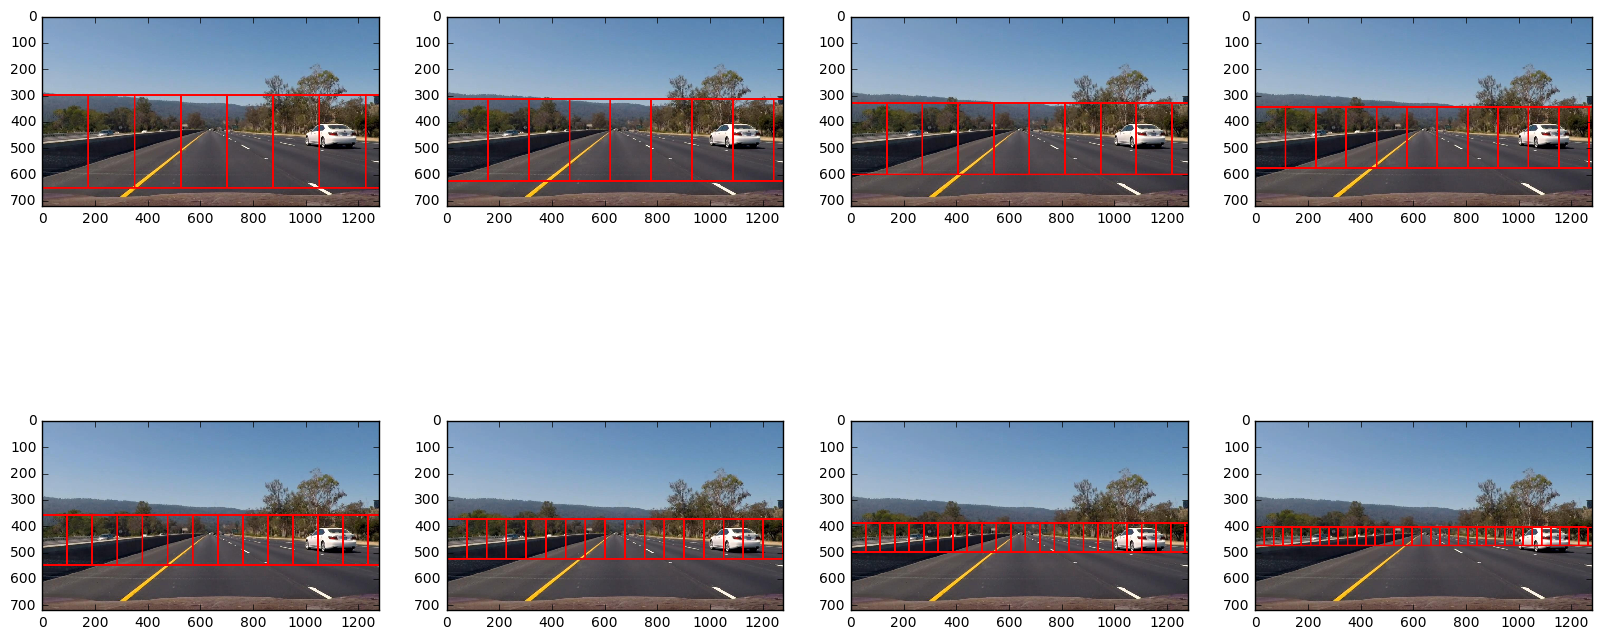

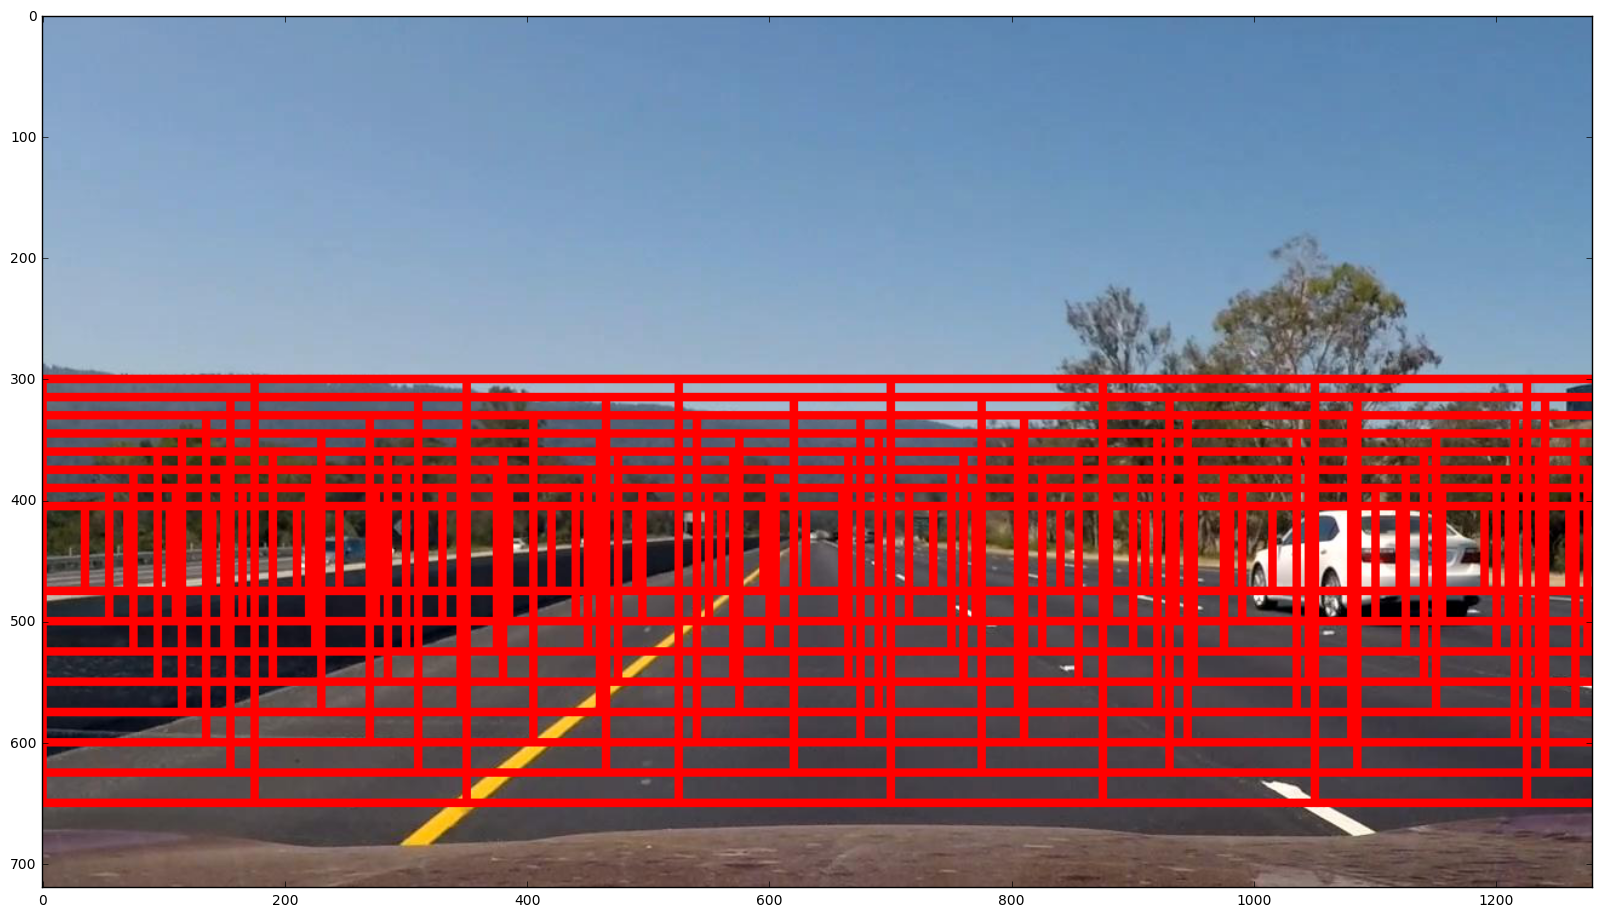

In [440]:
img = imread("data/vehicle_distances/white_2.jpg")
img_all = np.copy(img)
# Create window bands:
bottom = 650


right = 1280
size = 350
window_size_step = 40
bottom_step_size = int((window_size_step / 2) + (window_size_step / 8))
min_windows_size = 64

window_count = 0
window_bands = []
window_images = []
while size > min_windows_size:
    windows = slide_window(img,
                x_start_stop=(0, img.shape[1]),
                y_start_stop=(bottom - size, bottom),
                xy_window=(size, size),
                xy_overlap=(0.5, 0.0))
    
    window_count += len(windows)
    window_bands.append(windows)
    img_copy = np.copy(img)
    for window in windows:
        left = int(window[0][0])
        right = int(window[1][0])
        top = int(window[0][1])
        bottom = int(window[1][1])
        
        draw_rect(img_copy, bottom, right, size)
        draw_rect(img_all, bottom, right, size)


    window_images.append(img_copy)
    size = size - window_size_step
    bottom = bottom - bottom_step_size
    right = right - window_size_step * 2
    
print("Total number of windows: {0}".format(window_count))

for i in range(0, len(window_images)):    
    plt.subplot(int(len(window_images) / 2.0), int(len(window_images) / 2.0), i+1)
    plt.imshow(window_images[i])

plt.show()

plt.imshow(img_all)
plt.show()

The images above show the various window bands overlayed on the image, and then all the bands at once. These define the search area when looking for vehicles.

#### Testing the pipeline + feature reduction
"*Show some examples of test images to demonstrate how your pipeline is working. What did you do to try to minimize false positives and reliably detect cars?*"

As mentioned earlier in this project, I used an ExtraTreeClassifier to do feature reduction by finding features which have less predictive power. This reduces the number of featres per image and speeds up the classification process without loss of accuracy.

The pipeline is demonstrated below.

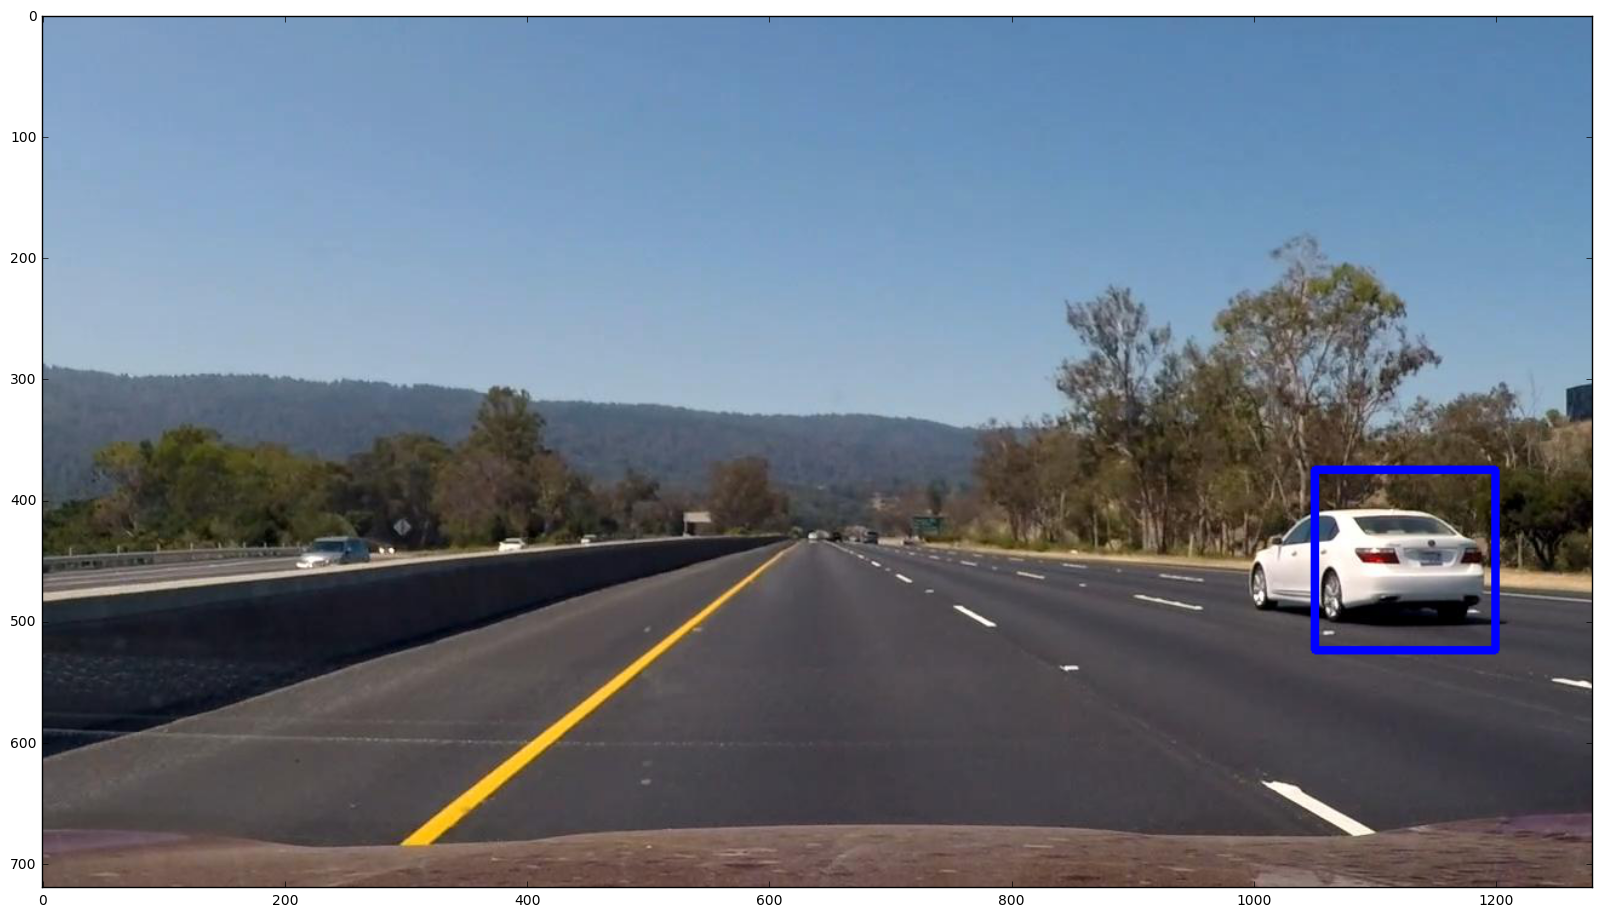

In [453]:
def detect(image):
    window_frames = []
    bounding_boxes = []
    for windows in window_bands:
        for window in windows:
            left = int(window[0][0])
            right = int(window[1][0])
            top = int(window[0][1])
            bottom = int(window[1][1])

            if left < 0 or top < 0 or bottom > image.shape[0] or right > image.shape[1]:
                continue

            w = image[top:bottom, left:right]

            w = cv2.resize(w, (64, 64))
            features = extract_features_from_image(w)

            window_frames.append([((left, top), (right, bottom)), features])

    window_frames = np.array(window_frames)
    predictions = clf.predict(np.vstack(window_frames[:, 1]))

    return window_frames[predictions == 'vehicle'][:, 0]

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

def add_heat(bbox_list, heatmap):
    COOL_RATE = 0.9
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1


    # Apply cooling
    heatmap *= COOL_RATE

    # Threshold heatmap
    heatmap[heatmap <= HEATMAP_THRESHOLD] = 0
    
    return heatmap
    
def process_frame(frame):
    heatmap = np.zeros(shape=(720, 1280))
    bounding_boxes = detect(frame)
    heatmap = add_heat(bounding_boxes, heatmap)
    labels = label(heatmap)
    return draw_labeled_bboxes(frame, labels)


img = imread("data/vehicle_distances/white_2.jpg")


# For this demo, the heatmap threshold is set to allow for any matches to show up since we aren't handling multiple frames.
HEATMAP_THRESHOLD = 0
img = process_frame(img)
plt.imshow(img)
plt.show()

### Video 

#### False positive correction with heatmaps
"*Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)*"

"*Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.*"


To handle false positives, I used a heatmap with heating and cooling + thresholding.

Here's the way the heating and cooling works:

1. Initialize an empty heatmap (all zeros for each XxY combination.
2. Each time a car is detected at a pixel, add one to the location.
3. Apply cooling at some rate. I used .9. To do this, the entire heat map is multiplied by the cool rate. This has the effect forcing coordinates which don't have consecutive positive classifications to "cool" down and approach zero.
4. Apply a small threshold to the heatmap. I used 2.

By this definiton, a pixel must have 2 consecutive detections in order to be considered a true positive, or it must have enough detections to cancel the cooling effect.

For example, pixel "A" might see the folliwng heatmap values:

* Frame 1: Vehicle! HM_A = 1
* Frame 2: No vehicle :(! HM_A = 0.9
* Frame 3: No vehicle :(! HM_A = 0.81
* Frame 4: Vehicle! HM_A = 1.81
* Frame 5: Vehicle! HM_A = 2.81. <--- True positive.

In this scenario, even if frame 6 is a negative classification, the pixel will still count as a vehicle. It will do this until the pixel heatmap value has cooled to < 2. This seems to work well.

My final video can be found in the submitted directory as "**project_video_out.mp4.**"